In [235]:
%pip install xgboost

import pandas as pd 
import numpy as np 
import os 
import requests
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy import stats 
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor

Note: you may need to restart the kernel to use updated packages.




Rule Change in 2015-2016: Teams to play with three skaters and a goaltender in regular-season overtime (84.1)
Rule Change in 2017-2018: Stricter enforcement of slashing penalties (61) and faceoffs (76)
Rule Change in 2013-2014: Shallower nets introduced; while opening remains 4′ x 6′, nets are 4″ shallower and 4″ narrower on each side behind the goal line.



Will X player be a Hall Of Famer

Will the shot go in the net on X goalie? Unsupervised using a features of player position, shot location, shot type, goalie stats

In [209]:
# Specify the folder where the CSV files are located
directory = '/Users/blairjdaniel/lighthouse/lighthouse/NHL/files/skaters'

# Use glob to find all CSV files in the dir
csv_files = glob.glob(os.path.join(directory, '*.csv'))

# Initialize an empty dataframe
dataframes = []

# Loop through the CSV file and read it into a DF
for csv_file in csv_files:
    goalies = pd.read_csv(csv_file)
    dataframes.append(goalies)

    # # Check if the file is goalies_2010.csv and print a message
    # if 'goalies_2010.csv' in csv_file:
    #     print(f"goalies_2010.csv file loaded successfully.")
    #     print(goalies.head())  # Display the first few rows of the DataFrame


# Concatenate all DF into one master DataFrame
skaters_df = pd.concat(dataframes, ignore_index=True)
len(skaters_df)

76675

In [210]:
skaters_df

,playerId,season,name,team,position,situation,games_played,icetime,shifts,gameScore,...,OffIce_A_shotAttempts,xGoalsForAfterShifts,xGoalsAgainstAfterShifts,corsiForAfterShifts,corsiAgainstAfterShifts,fenwickForAfterShifts,fenwickAgainstAfterShifts,ncentage,fenwickAgainstAfterShiftsame,offIce_corsiPer
0,8470144,2010,Frans Nielsen,NYI,C,other,71.0,2884.0,62.0,38.23,...,130.0,0.00,0.00,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1,8470144,2010,Frans Nielsen,NYI,C,all,71.0,75672.0,1692.0,48.22,...,3171.0,0.00,0.00,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2,8470144,2010,Frans Nielsen,NYI,C,5on5,71.0,50658.0,1130.0,48.22,...,2607.0,1.58,2.15,43.0,46.0,35.0,38.0,NaN,NaN,NaN
3,8470144,2010,Frans Nielsen,NYI,C,4on5,71.0,11891.0,313.0,48.22,...,338.0,0.03,0.06,2.0,4.0,2.0,2.0,NaN,NaN,NaN
4,8470144,2010,Frans Nielsen,NYI,C,5on4,71.0,10239.0,187.0,46.30,...,61.0,0.19,0.00,3.0,1.0,2.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76670,8471675,2009,Sidney Crosby,PIT,C,other,80.0,6307.0,106.0,98.50,...,157.0,0.00,0.12,0.0,5.0,0.0,3.0,NaN,NaN,NaN
76671,8471675,2009,Sidney Crosby,PIT,C,all,80.0,105401.0,1876.0,116.70,...,3040.0,0.00,0.00,0.0,0.0,0.0,0.0,NaN,NaN,NaN
76672,8471675,2009,Sidney Crosby,PIT,C,5on5,80.0,72074.0,1405.0,116.70,...,2182.0,0.70,2.30,26.0,58.0,21.0,48.0,NaN,NaN,NaN
76673,8471675,2009,Sidney Crosby,PIT,C,4on5,80.0,4112.0,156.0,97.36,...,591.0,0.00,0.00,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [211]:
# Check for non nulls and Dtypes
skaters_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76675 entries, 0 to 76674
Columns: 157 entries, playerId to offIce_corsiPer
dtypes: float64(147), int64(2), object(8)
memory usage: 91.8+ MB


In [212]:
# Check for any outliers or interesting stats
skaters_df.describe()

,playerId,season,games_played,icetime,shifts,gameScore,onIce_xGoalsPercentage,offIce_xGoalsPercentage,onIce_corsiPercentage,offIce_corsiPercentage,...,OffIce_F_shotAttempts,OffIce_A_shotAttempts,xGoalsForAfterShifts,xGoalsAgainstAfterShifts,corsiForAfterShifts,corsiAgainstAfterShifts,fenwickForAfterShifts,fenwickAgainstAfterShifts,fenwickAgainstAfterShiftsame,offIce_corsiPer
count,7.667500e+04,76675.000000,76675.000000,76675.000000,76675.000000,76675.000000,76675.000000,76675.000000,76675.000000,72055.000000,...,76675.000000,76675.000000,76675.000000,76675.000000,76675.000000,76675.000000,76675.000000,72055.000000,4620.000000,4620.000000
mean,8.474568e+06,2016.060972,96.119765,17692.952670,380.242478,16.737704,0.957109,0.685371,0.832504,0.470248,...,716.072690,717.050760,14.770833,0.322640,7.580139,4.181584,6.681728,3.364846,15.869089,3.153030
std,4.837530e+03,4.823866,352.555766,26999.411699,574.443634,21.149798,6.590512,2.652901,5.003670,0.257580,...,1028.965956,1030.838742,102.233951,1.149705,21.113922,10.101718,17.385931,8.276483,21.912622,7.960973
min,8.445550e+06,2008.000000,0.000000,0.000000,0.000000,-12.400000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.471348e+06,2012.000000,20.000000,364.000000,9.000000,0.530000,0.130000,0.210000,0.160000,0.350000,...,32.000000,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.380000,0.000000
50%,8.475208e+06,2016.000000,54.000000,3520.000000,74.000000,7.710000,0.470000,0.490000,0.480000,0.490000,...,123.000000,126.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.530000,0.000000
75%,8.477930e+06,2020.000000,76.000000,23845.000000,547.000000,26.600000,0.590000,0.570000,0.590000,0.550000,...,1268.500000,1240.000000,0.190000,0.090000,2.420000,2.000000,2.000000,1.000000,23.860000,1.000000
max,8.484911e+06,2023.000000,4797.000000,144666.000000,2730.000000,154.730000,232.000000,67.000000,170.000000,1.000000,...,4797.000000,4499.000000,1712.300000,20.360000,232.000000,100.000000,174.000000,78.000000,123.880000,59.000000


In [213]:
skaters_df.columns.tolist()

['playerId',
 'season',
 'name',
 'team',
 'position',
 'situation',
 'games_played',
 'icetime',
 'shifts',
 'gameScore',
 'onIce_xGoalsPercentage',
 'offIce_xGoalsPercentage',
 'onIce_corsiPercentage',
 'offIce_corsiPercentage',
 'onIce_fenwickPercentage',
 'offIce_fenwickPercentage',
 'iceTimeRank',
 'I_F_xOnGoal',
 'I_F_xGoals',
 'I_F_xRebounds',
 'I_F_xFreeze',
 'I_F_xPlayStopped',
 'I_F_xPlayContinuedInZone',
 'I_F_xPlayContinuedOutsideZone',
 'I_F_flurryAdjustedxGoals',
 'I_F_scoreVenueAdjustedxGoals',
 'I_F_flurryScoreVenueAdjustedxGoals',
 'I_F_primaryAssists',
 'I_F_secondaryAssists',
 'I_F_shotsOnGoal',
 'I_F_missedShots',
 'I_F_blockedShotAttempts',
 'I_F_shotAttempts',
 'I_F_points',
 'I_F_goals',
 'I_F_rebounds',
 'I_F_reboundGoals',
 'I_F_freeze',
 'I_F_playStopped',
 'I_F_playContinuedInZone',
 'I_F_playContinuedOutsideZone',
 'I_F_savedShotsOnGoal',
 'I_F_savedUnblockedShotAttempts',
 'penalties',
 'I_F_penalityMinutes',
 'I_F_faceOffsWon',
 'I_F_hits',
 'I_F_takeaways

In [214]:
# Initialize an empty list to store DataFrames
pivoted_dfs = []
cols_to_drop = ['team', 'games_played', 'icetime', 'shifts', 'gameScore', 'iceTimeRank', 'I_F_xPlayStopped', 'I_F_xPlayContinuedInZone',
 'I_F_xPlayContinuedOutsideZone', 'I_F_flurryAdjustedxGoals','OnIce_F_flurryAdjustedxGoals','OnIce_F_scoreVenueAdjustedxGoals',
 'OnIce_F_flurryScoreVenueAdjustedxGoals','I_F_scoreVenueAdjustedxGoals','I_F_flurryScoreVenueAdjustedxGoals', 'I_F_freeze',
 'I_F_playStopped','I_F_playContinuedInZone','I_F_playContinuedOutsideZone', 'penalties','I_F_penalityMinutes','I_F_faceOffsWon',
 'I_F_hits','I_F_takeaways','I_F_giveaways', 'I_F_dZoneGiveaways', 'I_F_xGoals_with_earned_rebounds_scoreAdjusted',
 'I_F_xGoals_with_earned_rebounds_scoreFlurryAdjusted','I_F_shifts','I_F_oZoneShiftStarts','I_F_dZoneShiftStarts',
 'I_F_neutralZoneShiftStarts','I_F_flyShiftStarts','I_F_oZoneShiftEnds','I_F_dZoneShiftEnds','I_F_neutralZoneShiftEnds',
 'I_F_flyShiftEnds','faceoffsWon','faceoffsLost','timeOnBench','penalityMinutes','penalityMinutesDrawn','penaltiesDrawn',
 'shotsBlockedByPlayer', 'OnIce_A_xGoals_with_earned_rebounds_scoreAdjusted','OnIce_A_xGoals_with_earned_rebounds_scoreFlurryAdjusted',
 'OffIce_F_xGoals','OffIce_A_xGoals','OffIce_F_shotAttempts','OffIce_A_shotAttempts','xGoalsForAfterShifts','xGoalsAgainstAfterShifts',
 'corsiForAfterShifts','corsiAgainstAfterShifts','fenwickForAfterShifts','fenwickAgainstAfterShifts','ncentage',
 'fenwickAgainstAfterShiftsame','offIce_corsiPer', 'I_F_blockedShotAttempts', 'I_F_primaryAssists', 'I_F_secondaryAssists',
 'I_F_xFreeze', 'OnIce_A_blockedShotAttempts', 'OnIce_A_flurryAdjustedxGoals','OnIce_A_flurryScoreVenueAdjustedxGoals',
 'OnIce_F_blockedShotAttempts', 'offIce_corsiPercentage','offIce_fenwickPercentage','offIce_xGoalsPercentage','onIce_corsiPercentage',
 'onIce_fenwickPercentage', 'I_F_highDangerxGoals', 'I_F_lowDangerxGoals', 'I_F_mediumDangerxGoals', 'I_F_missedShots', 
 'I_F_points', 'I_F_points','I_F_reboundGoals','I_F_rebounds','I_F_reboundxGoals', 'I_F_xGoals',
 'I_F_xGoalsFromActualReboundsOfShots','I_F_xGoalsFromxReboundsOfShots','I_F_xGoals_with_earned_rebounds','I_F_xOnGoal',
 'I_F_xRebounds', 'OnIce_A_highDangerxGoals', 'OnIce_A_lowDangerxGoals', 'OnIce_A_mediumDangerxGoals',
 'OnIce_A_missedShots','OnIce_A_reboundGoals','OnIce_A_rebounds','OnIce_A_reboundxGoals', 'OnIce_A_scoreAdjustedShotsAttempts',
 'OnIce_A_scoreAdjustedUnblockedShotAttempts','OnIce_A_scoreVenueAdjustedxGoals', 'OnIce_A_goals',
 'OnIce_A_highDangerGoals','OnIce_A_highDangerShots','OnIce_A_highDangerxGoals','OnIce_A_lowDangerGoals',
 'OnIce_A_lowDangerShots','OnIce_A_lowDangerxGoals','OnIce_A_mediumDangerGoals','OnIce_A_mediumDangerShots',
 'OnIce_A_mediumDangerxGoals','OnIce_A_missedShots','OnIce_A_reboundGoals','OnIce_A_rebounds',
 'OnIce_A_reboundxGoals','OnIce_A_scoreAdjustedShotsAttempts','OnIce_A_scoreAdjustedUnblockedShotAttempts',
 'OnIce_A_scoreVenueAdjustedxGoals','OnIce_A_shotAttempts','OnIce_A_shotsOnGoal','OnIce_A_unblockedShotAttempts',
 'OnIce_A_xGoals','OnIce_A_xGoalsFromActualReboundsOfShots','OnIce_A_xGoalsFromxReboundsOfShots',
 'OnIce_A_xGoals_with_earned_rebounds','OnIce_A_xOnGoal','OnIce_F_goals','OnIce_F_highDangerGoals',
 'OnIce_F_highDangerShots','OnIce_F_highDangerxGoals','OnIce_F_lowDangerGoals','OnIce_F_lowDangerShots',
 'OnIce_F_lowDangerxGoals','OnIce_F_mediumDangerGoals','OnIce_F_mediumDangerShots','OnIce_F_mediumDangerxGoals',
 'OnIce_F_missedShots','OnIce_F_reboundGoals','OnIce_F_rebounds','OnIce_F_reboundxGoals','OnIce_F_scoreAdjustedShotsAttempts',
 'OnIce_F_scoreAdjustedUnblockedShotAttempts','OnIce_F_shotAttempts','OnIce_F_shotsOnGoal','OnIce_F_unblockedShotAttempts',
 'OnIce_F_xGoals','OnIce_F_xGoalsFromActualReboundsOfShots','OnIce_F_xGoalsFromxReboundsOfShots',
 'OnIce_F_xGoals_with_earned_rebounds','OnIce_F_xGoals_with_earned_rebounds_scoreAdjusted',
 'OnIce_F_xGoals_with_earned_rebounds_scoreFlurryAdjusted','OnIce_F_xOnGoal','onIce_xGoalsPercentage', 'I_F_scoreAdjustedShotsAttempts',
 'I_F_scoreAdjustedUnblockedShotAttempts', 'I_F_savedUnblockedShotAttempts', 'I_F_unblockedShotAttempts']

# List of situations
situations = ['all']

# Loop through each situation and pivot the DataFrame
for situation in situations:
    # Filter the DataFrame for the specific situation
    situation_df = skaters_df[skaters_df['situation'] == situation]
    
    # Drop specific columns
    situation_df = situation_df.drop(columns=cols_to_drop)

    # Pivot the DataFrame
    pivoted_df = situation_df.pivot_table(index=['name', 'season'], aggfunc='first')
    
    # Flatten the columns
    pivoted_df.columns = [f'{col}_{situation}' for col in pivoted_df.columns]
    
    # Reset the index
    pivoted_df = pivoted_df.reset_index()
    
    # Append the pivoted DataFrame to the list
    pivoted_dfs.append(pivoted_df)

# Merge all pivoted DataFrames into one master DataFrame
df_all = pivoted_dfs[0]
for pivoted_df in pivoted_dfs[1:]:
    df_all = df_all.merge(pivoted_df, on=['name', 'season'], how='outer')

# Display the first few rows of the master DataFrame
print("Master DataFrame:")
df_all

Master DataFrame:


,name,season,I_F_goals_all,I_F_highDangerGoals_all,I_F_highDangerShots_all,I_F_lowDangerGoals_all,I_F_lowDangerShots_all,I_F_mediumDangerGoals_all,I_F_mediumDangerShots_all,I_F_savedShotsOnGoal_all,I_F_shotAttempts_all,I_F_shotsOnGoal_all,playerId_all,position_all,situation_all
0,A.J. Greer,2016,0.0,0.0,2.0,0.0,4.0,0.0,4.0,8.0,11.0,8.0,8478421,L,all
1,A.J. Greer,2017,0.0,0.0,0.0,0.0,13.0,0.0,2.0,13.0,20.0,13.0,8478421,L,all
2,A.J. Greer,2018,1.0,1.0,2.0,0.0,5.0,0.0,4.0,8.0,14.0,9.0,8478421,L,all
3,A.J. Greer,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8478421,L,all
4,A.J. Greer,2021,1.0,1.0,3.0,0.0,10.0,0.0,3.0,13.0,20.0,14.0,8478421,L,all
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14399,Zenon Konopka,2009,2.0,2.0,8.0,0.0,34.0,0.0,16.0,39.0,66.0,41.0,8469820,C,all
14400,Zenon Konopka,2010,2.0,0.0,5.0,0.0,43.0,2.0,21.0,54.0,76.0,56.0,8469820,C,all
14401,Zenon Konopka,2011,3.0,1.0,2.0,2.0,35.0,0.0,8.0,31.0,53.0,34.0,8469820,C,all
14402,Zenon Konopka,2012,0.0,0.0,1.0,0.0,15.0,0.0,7.0,18.0,29.0,18.0,8469820,C,all


In [215]:
df_all.columns.tolist()

['name',
 'season',
 'I_F_goals_all',
 'I_F_highDangerGoals_all',
 'I_F_highDangerShots_all',
 'I_F_lowDangerGoals_all',
 'I_F_lowDangerShots_all',
 'I_F_mediumDangerGoals_all',
 'I_F_mediumDangerShots_all',
 'I_F_savedShotsOnGoal_all',
 'I_F_shotAttempts_all',
 'I_F_shotsOnGoal_all',
 'playerId_all',
 'position_all',
 'situation_all']

In [216]:
df_all_grouped = df_all.groupby(by=['name'])


In [217]:
# Convert the grouped DataFrame to a regular DataFrame
df_all_reset = df_all_grouped.sum().reset_index()
df_all = df_all_reset.drop(columns=['season', 'situation_all'])
df_all

,name,I_F_goals_all,I_F_highDangerGoals_all,I_F_highDangerShots_all,I_F_lowDangerGoals_all,I_F_lowDangerShots_all,I_F_mediumDangerGoals_all,I_F_mediumDangerShots_all,I_F_savedShotsOnGoal_all,I_F_shotAttempts_all,I_F_shotsOnGoal_all,playerId_all,position_all
0,A.J. Greer,13.0,7.0,23.0,5.0,135.0,1.0,58.0,154.0,283.0,167.0,59348947,LLLLLLL
1,Aaron Downey,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,2.0,8465992,R
2,Aaron Ekblad,114.0,28.0,70.0,62.0,2022.0,24.0,190.0,1572.0,3168.0,1686.0,84779320,DDDDDDDDDD
3,Aaron Gagnon,3.0,0.0,3.0,1.0,35.0,2.0,8.0,25.0,59.0,28.0,33885804,CCCC
4,Aaron Johnson,10.0,4.0,7.0,6.0,191.0,0.0,7.0,125.0,288.0,135.0,33878136,DDDD
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2858,Zack Stortini,10.0,3.0,14.0,3.0,84.0,4.0,36.0,76.0,179.0,86.0,33882748,RRRR
2859,Zbynek Michalek,24.0,3.0,9.0,16.0,890.0,5.0,22.0,640.0,1366.0,664.0,76227840,DDDDDDDDD
2860,Zdeno Chara,124.0,34.0,82.0,69.0,2736.0,21.0,144.0,2015.0,4288.0,2139.0,118510126,DDDDDDDDDDDDDD
2861,Zemgus Girgensons,89.0,25.0,94.0,22.0,870.0,42.0,394.0,917.0,1667.0,1006.0,84768780,CCCCCCCLLL


In [218]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2863 entries, 0 to 2862
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   name                       2863 non-null   object 
 1   I_F_goals_all              2863 non-null   float64
 2   I_F_highDangerGoals_all    2863 non-null   float64
 3   I_F_highDangerShots_all    2863 non-null   float64
 4   I_F_lowDangerGoals_all     2863 non-null   float64
 5   I_F_lowDangerShots_all     2863 non-null   float64
 6   I_F_mediumDangerGoals_all  2863 non-null   float64
 7   I_F_mediumDangerShots_all  2863 non-null   float64
 8   I_F_savedShotsOnGoal_all   2863 non-null   float64
 9   I_F_shotAttempts_all       2863 non-null   float64
 10  I_F_shotsOnGoal_all        2863 non-null   float64
 11  playerId_all               2863 non-null   int64  
 12  position_all               2863 non-null   object 
dtypes: float64(10), int64(1), object(2)
memory usage

In [219]:
# Change the values in the 'position_all' column based on the position
df_all['position_all'] = np.where(df_all['position_all'].str.contains('L'), 'L', df_all['position_all'])
df_all['position_all'] = np.where(df_all['position_all'].str.contains('D'), 'D', df_all['position_all'])
df_all['position_all'] = np.where(df_all['position_all'].str.contains('C'), 'C', df_all['position_all'])
df_all['position_all'] = np.where(df_all['position_all'].str.contains('R'), 'R', df_all['position_all'])

# Display the updated 'position_all' column
print(df_all['position_all'])



0       L
1       R
2       D
3       C
4       D
       ..
2858    R
2859    D
2860    D
2861    L
2862    C
Name: position_all, Length: 2863, dtype: object


In [220]:
# Use encoding to give the positions a numeric value
le = LabelEncoder()
df_all['position_all'] = df_all['position_all'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x) 

# Fit the encoder and transform the 'position_all' column
df_all['PositionEn_encoded'] = le.fit_transform(df_all['position_all'])
df_all = df_all.drop(columns=['position_all'])

In [221]:
df_all.head()

,name,I_F_goals_all,I_F_highDangerGoals_all,I_F_highDangerShots_all,I_F_lowDangerGoals_all,I_F_lowDangerShots_all,I_F_mediumDangerGoals_all,I_F_mediumDangerShots_all,I_F_savedShotsOnGoal_all,I_F_shotAttempts_all,I_F_shotsOnGoal_all,playerId_all,PositionEn_encoded
0,A.J. Greer,13.0,7.0,23.0,5.0,135.0,1.0,58.0,154.0,283.0,167.0,59348947,2
1,Aaron Downey,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,2.0,8465992,3
2,Aaron Ekblad,114.0,28.0,70.0,62.0,2022.0,24.0,190.0,1572.0,3168.0,1686.0,84779320,1
3,Aaron Gagnon,3.0,0.0,3.0,1.0,35.0,2.0,8.0,25.0,59.0,28.0,33885804,0
4,Aaron Johnson,10.0,4.0,7.0,6.0,191.0,0.0,7.0,125.0,288.0,135.0,33878136,1


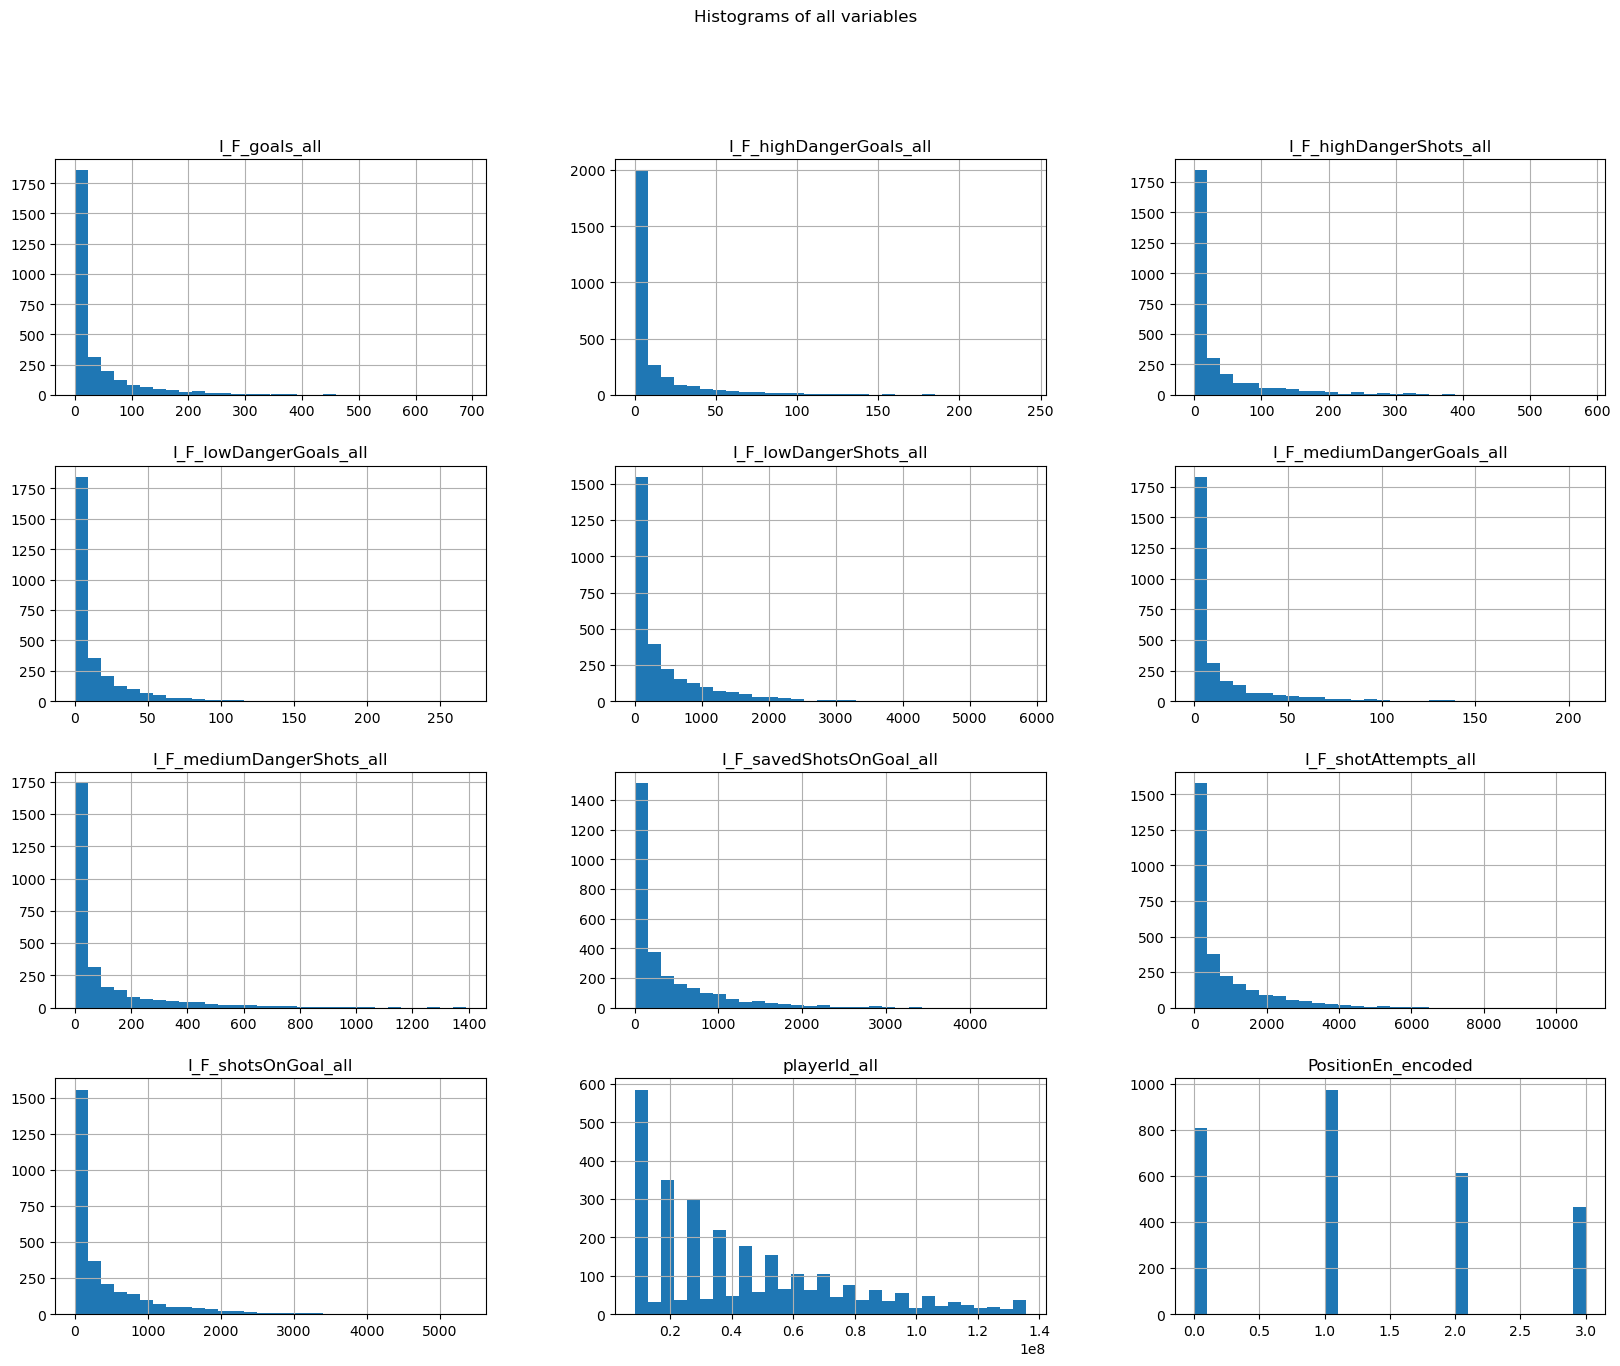

In [222]:
# Histogram for each variable
df_all.hist(bins=30, figsize=(20, 15))
plt.suptitle('Histograms of all variables')
plt.show()

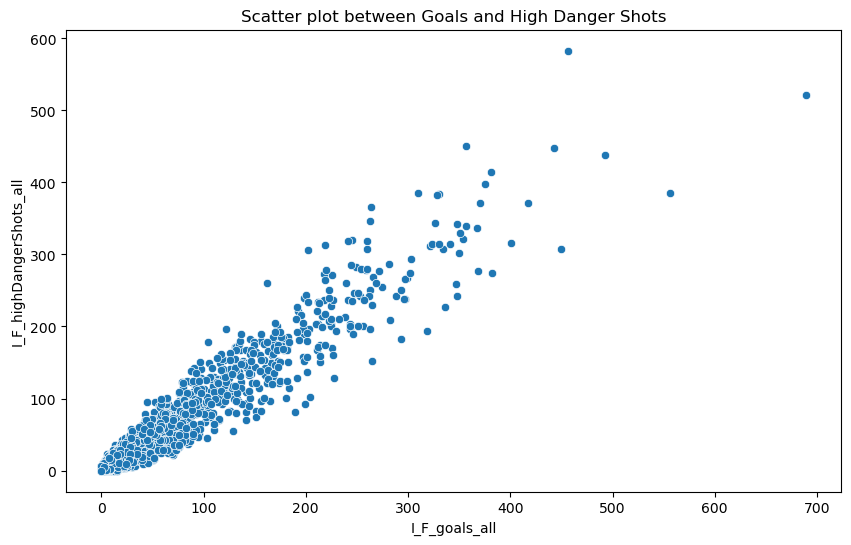

In [223]:
# Scatter plot between "Fresh" and "Milk"
plt.figure(figsize=(10, 6))
sns.scatterplot(x='I_F_goals_all', y='I_F_highDangerShots_all', data=df_all)
plt.title('Scatter plot between Goals and High Danger Shots')
plt.show()

In [224]:
# Z-score method to detect outliers, looked into these on Google as quick ways to find outliers
z_scores = stats.zscore(df_all.select_dtypes(include=[float, int]))
abs_z_scores = abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df_no_outliers = df_all[filtered_entries]

# Display the cleaned dataset without outliers
df_no_outliers.head()

,name,I_F_goals_all,I_F_highDangerGoals_all,I_F_highDangerShots_all,I_F_lowDangerGoals_all,I_F_lowDangerShots_all,I_F_mediumDangerGoals_all,I_F_mediumDangerShots_all,I_F_savedShotsOnGoal_all,I_F_shotAttempts_all,I_F_shotsOnGoal_all,playerId_all,PositionEn_encoded
0,A.J. Greer,13.0,7.0,23.0,5.0,135.0,1.0,58.0,154.0,283.0,167.0,59348947,2
1,Aaron Downey,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,2.0,8465992,3
2,Aaron Ekblad,114.0,28.0,70.0,62.0,2022.0,24.0,190.0,1572.0,3168.0,1686.0,84779320,1
3,Aaron Gagnon,3.0,0.0,3.0,1.0,35.0,2.0,8.0,25.0,59.0,28.0,33885804,0
4,Aaron Johnson,10.0,4.0,7.0,6.0,191.0,0.0,7.0,125.0,288.0,135.0,33878136,1


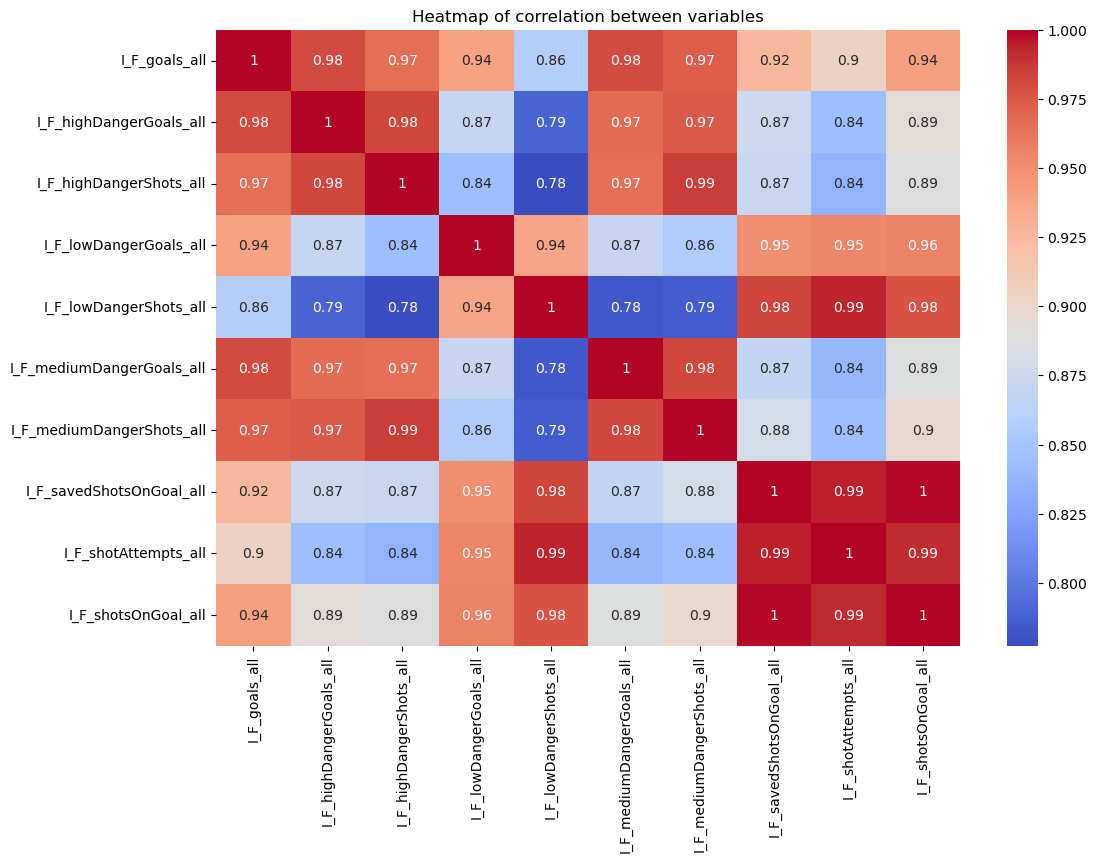

In [225]:
# Heatmap to show correlation between variables
numeric_df = df_all.drop(columns=['name', 'playerId_all', 'PositionEn_encoded'])


plt.figure(figsize=(12, 8))
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap of correlation between variables')
plt.show()

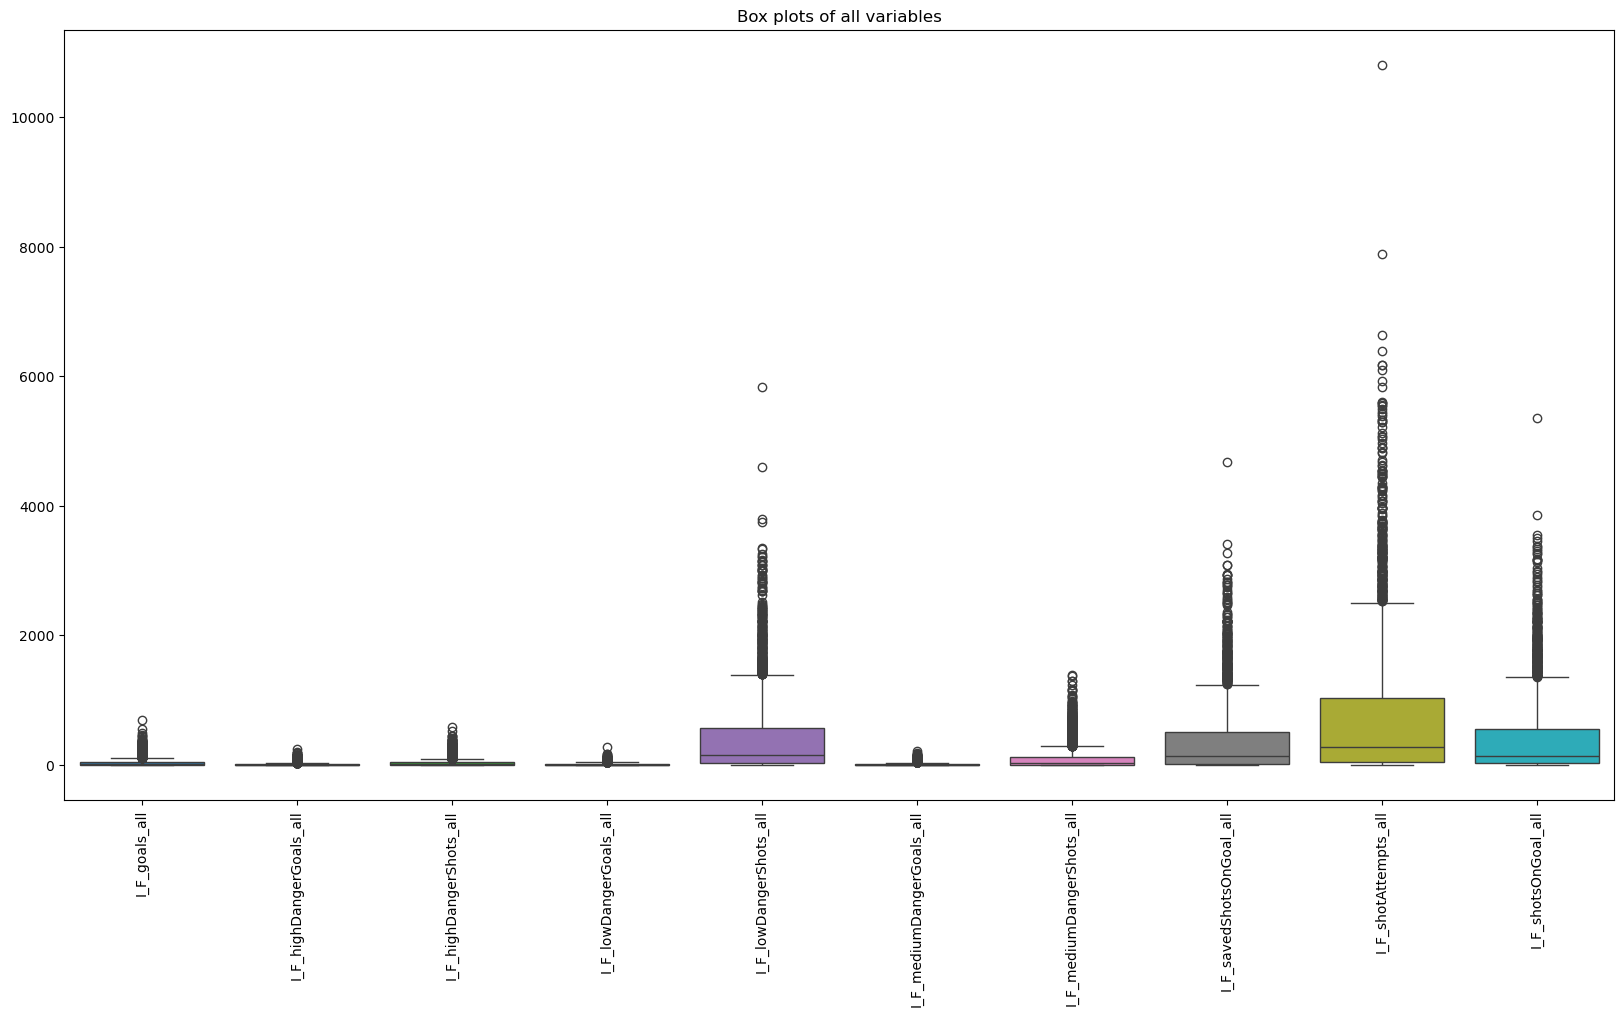

In [226]:
# Box plot for each variable
plt.figure(figsize=(20, 10))
sns.boxplot(data=numeric_df)
plt.title('Box plots of all variables')
plt.xticks(rotation=90)
plt.show()

Make the model using whichever works then use the housing_predictions to guess the player, then use that on will it go in on a certain goalie

In [227]:
df_all_numeric = df_all.drop(columns=['name'])
# Assuming df_all_numeric is already loaded and you have defined your features and target
X = df_all_numeric.drop(columns=['I_F_goals_all'])  # Replace 'target_column' with your actual target column I_F_goals_all
y = df_all_numeric['I_F_goals_all']  # Replace 'target_column' with your actual target column I_F_goals_all

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

# Initialize PCA
pca = PCA(n_components=0.95)  # Adjust the number of components or variance ratio as needed

# Fit PCA on the scaled training data and transform the training data
X_train_pca = pca.fit_transform(X_train_scaled)

# Transform the test data using the same PCA transformation
X_test_pca = pca.transform(X_test_scaled)

# Display the transformed training data
print("Transformed training data:")
print(X_train_pca)

# Display the transformed test data
print("Transformed test data:")
print(X_test_pca)

Transformed training data:
[[-1.82001681  1.69615371  0.02152341]
 [-1.66344524  0.72406416 -0.01504737]
 [-1.66914657  1.70009722  0.00386601]
 ...
 [ 2.74975192 -0.52618904  1.60200906]
 [-1.06535069 -0.33078691  0.42572695]
 [-1.69597324 -0.22203733 -0.17872751]]
Transformed test data:
[[ 7.19482381e+00 -1.27992090e+00  2.37856807e-01]
 [-4.50923612e-01 -3.37311008e-01  4.94095128e-01]
 [-1.69373817e+00  1.69945105e+00  4.17890803e-03]
 ...
 [ 4.96324540e+00 -1.13134086e+00 -6.44644874e-01]
 [ 8.67494048e+00 -8.78197620e-01  3.70927886e+00]
 [-1.89394449e+00 -2.07169626e-01 -2.74385339e-01]]


In [228]:
# Initialize the RandomForestRegressor
model = RandomForestRegressor(random_state=42)

# Train the model on the training data
model.fit(X_train_pca, y_train)

RandomForestRegressor(random_state=42)

In [229]:
# Make predictions on the test data
y_pred = model.predict(X_test_pca)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate the R^2 score
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2}")

# Calculate the number of observations (samples) and the number of predictors (features)
n = X_test_pca.shape[0]
p = X_test_pca.shape[1]

# Calculate the adjusted R-squared score
r2_adj = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

# Print the adjusted R-squared score
print(f"Adjusted R^2 Score: {r2_adj}")


Mean Squared Error: 62.5017919720768
R^2 Score: 0.9847643754170768
Adjusted R^2 Score: 0.9846840469922108


In [230]:
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions on the test data
y_pred = model.predict(X_test_pca)

# Calculate the mean squared error on the test data
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (Test): {mse}")

# Calculate the R^2 score on the test data
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score (Test): {r2}")

# Calculate the number of observations (samples) and the number of predictors (features) for the test data
n = X_test_pca.shape[0]
p = X_test_pca.shape[1]

# Calculate the adjusted R-squared score on the test data
r2_adj = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)
print(f"Adjusted R^2 Score (Test): {r2_adj}")

# Make predictions on the training data
y_train_pred = model.predict(X_train_pca)

# Calculate the mean squared error on the training data
mse_train = mean_squared_error(y_train, y_train_pred)
print(f"Mean Squared Error (Train): {mse_train}")

# Calculate the R^2 score on the training data
r2_train = r2_score(y_train, y_train_pred)
print(f"R^2 Score (Train): {r2_train}")

# Calculate the number of observations (samples) and the number of predictors (features) for the training data
n_train = X_train_pca.shape[0]
p_train = X_train_pca.shape[1]

# Calculate the adjusted R-squared score on the training data
r2_adj_train = 1 - ((1 - r2_train) * (n_train - 1)) / (n_train - p_train - 1)
print(f"Adjusted R^2 Score (Train): {r2_adj_train}")

Mean Squared Error (Test): 62.5017919720768
R^2 Score (Test): 0.9847643754170768
Adjusted R^2 Score (Test): 0.9846840469922108
Mean Squared Error (Train): 11.438215283842794
R^2 Score (Train): 0.9974882127745953
Adjusted R^2 Score (Train): 0.9974849164659005


In [233]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Define the model
model = GradientBoostingRegressor()

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of boosting stages to be run
    'max_depth': [3, 4, 5, 6],  # Maximum depth of the individual regression estimators
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Learning rate shrinks the contribution of each tree
    'subsample': [0.6, 0.8, 1.0],  # Fraction of samples used for fitting the individual base learners
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Set up the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')

# Execute the search
grid_search.fit(X_train_pca, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions
predictions = best_model.predict(X_test_pca)
print(f"Best Parameters: {grid_search.best_params_}")

# Calculate metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
adjusted_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test_pca.shape[1] - 1)

# Print metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R²: {r2}")
print(f"Adjusted R²: {adjusted_r2}")

Best Parameters: {'learning_rate': 0.05, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200, 'subsample': 0.6}
Mean Squared Error (MSE): 56.4595049228103
Root Mean Squared Error (RMSE): 7.5139540138871155
Mean Absolute Error (MAE): 4.035437500246803
R²: 0.9862372614608244
Adjusted R²: 0.986164698691725


In [ ]:
# Define the model
model = XGBRegressor()

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0.5, 1, 1.5, 2]
}

# Set up the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')

# Execute the search
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions
predictions = best_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
adjusted_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

# Print metrics
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R²: {r2}")
print(f"Adjusted R²: {adjusted_r2}")